### Convolutional Sequence to Sequence Learning

### Introduction
In this notebook we will cover a lot on how we can do [sequence to sequence using convulutional networks](https://arxiv.org/abs/1705.03122). In the past notebooks we have been working with Recurrent Neural Networks to perform such a task. This time around we want to see how we can do it using conv nets.


<p align="center">
<img src="https://github.com/bentrevett/pytorch-seq2seq/raw/49df8404d938a6edbf729876405558cc2c2b3013/assets/convseq2seq0.png"/>
</p>

Conv Nets are performs a good task on images. If you want to learn more about conv nets and sequence please look for sentiment analysis convnets notebook.

In short, a convolutional layer uses filters. These filters have a width (and also a height in images, but usually not text). If a filter has a width of 3, then it can see 3 consecutive tokens. Each convolutional layer has many of these filters (1024 in this tutorial). Each filter will slide across the sequence, from beginning to the end, looking at all 3 consectuive tokens at a time. The idea is that each of these 1024 filters will learn to extract a different feature from the text. The result of this feature extraction will then be used by the model - potentially as input to another convolutional layer. This can then all be used to extract features from the source sentence to translate it into the target language.

### Imports


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchtext.legacy import data, datasets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy, os, random, time, math
from prettytable import PrettyTable


### Seeds

In [2]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deteministic = True

### Next we'll load the `spaCy` models and define the tokenizer for bothe the Target and Source languages.

In [3]:
import spacy
import spacy.cli
spacy.cli.download('de_core_news_sm')

import de_core_news_sm, en_core_web_sm

spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')


### Preprocessing function that tokenizes sentences.

In [4]:
def tokenize_de(sent):
  return [tok.text for tok in spacy_de.tokenizer(sent)]

def tokenize_en(sent):
  return [tok.text for tok in spacy_en.tokenizer(sent)]

Next, we'll set up the `Fields` which decide how the data will be processed. By default `RNN` models in `PyTorch` require the sequence to be a tensor of shape **`[sequence length, batch size]`** so `TorchText` will, by default, return batches of tensors in the same shape. 

However in this notebook we are using `CNNs` which expect the batch dimension to be first. We tell `TorchText` to have batches be **`[batch size, sequence length]`** by setting `batch_first = True`.

We also append the start and end of sequence tokens as well as lowercasing all text.

In [5]:
SRC = data.Field(
    tokenize = tokenize_de,
    lower= True,
    init_token = "<sos>",
    eos_token = "<eos>",
    batch_first = True
)
TRG = data.Field(
    tokenize = tokenize_en,
    lower= True,
    init_token = "<sos>",
    eos_token = "<eos>",
    batch_first = True
)

### Loading the `Multi30k` dataset.

In [6]:
train_data, valid_data, test_data = datasets.Multi30k.splits(
    exts=('.de', '.en'),
    fields = (SRC, TRG)
)

### Checking examples for each subset.

In [7]:
def tabulate(column_names, data):
  table = PrettyTable(column_names)
  table.title= "VISUALIZING SETS EXAMPLES"
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)

column_names = ["SUBSET", "EXAMPLE(s)"]
row_data = [
        ["training", len(train_data)],
        ['validation', len(valid_data)],
        ['test', len(test_data)]
]
tabulate(column_names, row_data)

+-----------------------------+
|  VISUALIZING SETS EXAMPLES  |
+--------------+--------------+
| SUBSET       |   EXAMPLE(s) |
+--------------+--------------+
| training     |        29000 |
| validation   |         1014 |
| test         |         1000 |
+--------------+--------------+


### Checking a single example.

In [8]:
print(vars(train_data[0]))

{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


### Building the vocabulary.

When building the vocabulary,we will set all the tokens that appears less than 2 times to be `<unk>` (unknown). We do this by setting the `min_freq=2` for both the `SRC` and the `TRG`.

In [9]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

### Device.

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Building Iterators.
We are going to use our favourite iterator known as the `BucketIterator` to create iterators for all the sets. Unlike from the previous notebook where we used packed padded sequences we are not going to pass params like:
```
sort_key= sort_key,
sort_within_batch = True
```

In [11]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    device = device,
    batch_size = BATCH_SIZE,
)

### Building the Model.
As before, the model is made of an encoder and decoder. The encoder encodes the input sentence, in the source language, into a context vector. The decoder decodes the context vector to produce the output sentence in the target language.

### Encoder

Previous models had an encoder that compresses an entire input sentence into a single context vector, $z$. The convolutional sequence-to-sequence model is a little different - it gets two context vectors for each token in the input sentence. So, if our input sentence had 6 tokens, we would get 12 context vectors, two for each token.

The two context vectors per token are a conved vector and a combined vector. The conved vector is the result of each token being passed through a few layers - which we will explain shortly. The combined vector comes from the sum of the convolved vector and the embedding of that token. Both of these are returned by the encoder to be used by the decoder.

The image below shows the result of an input sentence - _zwei menschen fechten_. - being passed through the encoder.

<p align="center">
<img src="https://github.com/bentrevett/pytorch-seq2seq/raw/49df8404d938a6edbf729876405558cc2c2b3013/assets/convseq2seq1.png"/>
</p>

1. First, the token is passed through a token embedding layer - which is standard for neural networks in natural language processing. However, as there are no recurrent connections in this model it has no idea about the order of the tokens within a sequence. To rectify this we have a second embedding layer, the positional embedding layer. This is a standard embedding layer where the input is not the token itself but the position of the token within the sequence - starting with the first token, the <sos> (start of sequence) token, in position 0.

2. Next, the token and positional embeddings are elementwise summed together to get a vector which contains information about the token and also its position with in the sequence - which we simply call the embedding vector. This is followed by a linear layer which transforms the embedding vector into a vector with the required hidden dimension size.

3. The next step is to pass this hidden vector into $N$ convolutional blocks. This is where the "magic" happens in this model and we will detail the contents of the convolutional blocks shortly. After passing through the convolutional blocks, the vector is then fed through another linear layer to transform it back from the hidden dimension size into the embedding dimension size. This is our conved vector - and we have one of these per token in the input sequence.

4. Finally, the conved vector is elementwise summed with the embedding vector via a residual connection to get a combined vector for each token. Again, there is a combined vector for each token in the input sequence.

### Convolutional Blocks
So, how do these convolutional blocks work? The below image shows 2 convolutional blocks with a single filter (blue) that is sliding across the tokens within the sequence. In the actual implementation we will have 10 convolutional blocks with 1024 filters in each block.

<p align="">
<img src="https://github.com/bentrevett/pytorch-seq2seq/raw/49df8404d938a6edbf729876405558cc2c2b3013/assets/convseq2seq2.png"/>
</p>

First, the input sentence is padded. This is because the convolutional layers will reduce the length of the input sentence and we want the length of the sentence coming into the convolutional blocks to equal the length of it coming out of the convolutional blocks. Without padding, the length of the sequence coming out of a convolutional layer will be filter_size - 1 shorter than the sequence entering the convolutional layer. For example, if we had a filter size of 3, the sequence will be 2 elements shorter. Thus, we pad the sentence with one padding element on each side. We can calculate the amount of padding on each side by simply doing (filter_size - 1)/2 for odd sized filters - we will not cover even sized filters in this tutorial.

These filters are designed so the output hidden dimension of them is twice the input hidden dimension. In computer vision terminology these hidden dimensions are called channels - but we will stick to calling them hidden dimensions. Why do we double the size of the hidden dimension leaving the convolutional filter? This is because we are using a special activation function called **`gated linear units`** `(GLU)`. `GLUs` have gating mechanisms (similar to LSTMs and GRUs) contained within the activation function and actually half the size of the hidden dimension - whereas usually activation functions keep the hidden dimensions the same size.

After passing through the GLU activation the hidden dimension size for each token is the same as it was when it entered the convolutional blocks. It is now elementwise summed with its own vector before it was passed through the convolutional layer.

This concludes a single convolutional block. Subsequent blocks take the output of the previous block and perform the same steps. Each block has their own parameters, they are not shared between blocks. The output of the last block goes back to the main encoder - where it is fed through a linear layer to get the conved output and then elementwise summed with the embedding of the token to get the combined output.

### Encoder Implementation
To keep the implementation simple, we only allow for odd sized kernels. This allows padding to be added equally to both sides of the source sequence.

The scale variable is used by the authors to **"ensure that the variance throughout the network does not change dramatically"**. The performance of the model seems to vary wildly using different seeds if this is not used.

The positional embedding is initialized to have a **"vocabulary"** of 100. This means it can handle sequences up to 100 elements long, indexed from 0 to 99. This can be increased if used on a dataset with longer sequences.

In [12]:
class Encoder(nn.Module):
  def __init__(self, input_dim, emb_dim,
               hid_dim, n_layers, kernel_size, dropout,
               device, max_length=100
               ):
    super(Encoder, self).__init__()

    """
    CHECKING FOR ODD KERNEL_SIZE
    """
    assert kernel_size%2 == 1 , "KERNEL SIZE MUST BE ODD!"
    self.device = device
    self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
    self.tok_embedding = nn.Embedding(input_dim, emb_dim)
    self.pos_embedding = nn.Embedding(max_length, emb_dim)

    self.emb2hid = nn.Linear(emb_dim, hid_dim)
    self.hid2emb = nn.Linear(hid_dim, emb_dim)

    self.convs = nn.ModuleList([
        nn.Conv1d(
        in_channels = hid_dim, 
        out_channels = 2 * hid_dim, 
        kernel_size = kernel_size, 
        padding = (kernel_size - 1) // 2) for _ in range(n_layers)
    ])
    self.dropout = nn.Dropout(dropout)

  def forward(self, src):
    # src = [batch size, src len]
    batch_size = src.shape[0]
    src_len  = src.shape[1]
    # create position tensor
    pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
    """
    pos = [0, 1, 2, 3, ..., src len - 1]
    pos = [batch size, src len]
    """
    #embed tokens and positions
    tok_embedded = self.tok_embedding(src)
    pos_embedded = self.pos_embedding(pos)
    # tok_embedded = pos_embedded = [batch size, src len, emb dim]
    
    # combine embeddings by elementwise summing
    embedded = self.dropout(tok_embedded + pos_embedded)
    
    # embedded = [batch size, src len, emb dim]
    
    # pass embedded through linear layer to convert from emb dim to hid dim
    conv_input = self.emb2hid(embedded)
    
    # conv_input = [batch size, src len, hid dim]
    
    # permute for convolutional layer
    conv_input = conv_input.permute(0, 2, 1) 
    
    """
    conv_input = [batch size, hid dim, src len]
    begin convolutional blocks...
    """
    for i, conv in enumerate(self.convs):
      #pass through convolutional layer
      conved = conv(self.dropout(conv_input))
      # conved = [batch size, 2 * hid dim, src len]
      # pass through GLU activation function
      conved = F.glu(conved, dim = 1)

      # conved = [batch size, hid dim, src len]
      # apply residual connection
      conved = (conved + conv_input) * self.scale

      # conved = [batch size, hid dim, src len]
      
      # set conv_input to conved for next loop iteration
      conv_input = conved
    
    # ...end convolutional blocks
    
    # permute and convert back to emb dim
    conved = self.hid2emb(conved.permute(0, 2, 1))
    
    # conved = [batch size, src len, emb dim]
    # elementwise sum output (conved) and input (embedded) to be used for attention
    combined = (conved + embedded) * self.scale
    # combined = [batch size, src len, emb dim]
    return conved, combined

### Decoder
The decoder takes in the actual target sentence and tries to predict it. This model differs from the recurrent neural network models previously detailed in these tutorials as it predicts all tokens within the target sentence in parallel. There is no sequential processing, i.e. no decoding loop. This will be detailed further later on in the tutorials.

The decoder is similar to the encoder, with a few changes to both the main model and the convolutional blocks inside the model.

<p align="center">
<img src="https://github.com/bentrevett/pytorch-seq2seq/raw/49df8404d938a6edbf729876405558cc2c2b3013/assets/convseq2seq3.png"/>
</p>
First, the embeddings do not have a residual connection that connects after the convolutional blocks and the transformation. Instead the embeddings are fed into the convolutional blocks to be used as residual connections there.

Second, to feed the decoder information from the encoder, the encoder conved and combined outputs are used - again, within the convolutional blocks.

Finally, the output of the decoder is a linear layer from embedding dimension to output dimension. This is used make a prediction about what the next word in the translation should be.

### Decoder Convolutional Blocks
Again, these are similar to the convolutional blocks within the encoder, with a few changes.

<p align="center">
<img src="https://github.com/bentrevett/pytorch-seq2seq/raw/49df8404d938a6edbf729876405558cc2c2b3013/assets/convseq2seq4.png"/>
</p>

First, the padding. Instead of padding equally on each side to ensure the length of the sentence stays the same throughout, we only pad at the beginning of the sentence. As we are processing all of the targets simultaneously in parallel, and not sequentially, we need a method of only allowing the filters translating token $i$ to only look at tokens before word $i$. If they were allowed to look at token $i+1$ (the token they should be outputting), the model will simply learn to output the next word in the sequence by directly copying it, without actually learning how to translate.

Let's see what happens if we **incorrectly** padded equally on each side, like we do in the encoder.
<p align="center">
<img src="https://github.com/bentrevett/pytorch-seq2seq/raw/49df8404d938a6edbf729876405558cc2c2b3013/assets/convseq2seq5.png"/>
</p>

The filter at the first position, which is trying use the first word in the sequence, `<sos>` to predict the second word, two, can now directly see the word two. This is the same for every position, the word the model trying to predict is the second element covered by the filter. Thus, the filters can learn to simply copy the second word at each position allowing for perfect translation without actually learning how to translate.

Second, after the GLU activation and before the residual connection, the block calculates and applies attention - using the encoded representations and the embedding of the current word. Note: we only show the connections to the rightmost token, but they are actually connected to all tokens - this was done for clarity. Each token input uses their own, and only their own, embedding for their own attention calculation.

The attention is calculated by first using a linear layer to change the hidden dimension to the same size as the embedding dimension. Then the embedding summed via a residual connection. This combination then has the standard attention calculation applied by finding how much it "matches" with the encoded conved and then this is applied by getting a weighted sum over the encoded combined. This is then projected back up to the hidden dimenson size and a residual connection to the initial input to the attention layer is applied.

Why do they calculate attention first with the encoded conved and then use it to calculate the weighted sum over the encoded combined? The paper argues that the encoded conved is good for getting a larger context over the encoded sequence, whereas the encoded combined has more information about the specific token and is thus therefore more useful for makng a prediction.

### Decoder Impementation
As we only pad on one side the decoder is allowed to use both odd and even sized padding. Again, the scale is used to reduce variance throughout the model and the position embedding is initialized to have a "vocabulary" of 100.

This model takes in the encoder representations in its forward method and both are passed to the `calculate_attention` method which calculates and applies attention. It also returns the actual attention values, but we are not currently using them.

In [13]:
class Decoder(nn.Module):
  def __init__(self, output_dim, emb_dim, hid_dim, n_layers, kernel_size, 
                 dropout, trg_pad_idx, device,max_length = 100
                 ):
    super(Decoder, self).__init__()
    
    self.kernel_size = kernel_size
    self.trg_pad_idx = trg_pad_idx
    self.device = device
    
    self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
    
    self.tok_embedding = nn.Embedding(output_dim, emb_dim)
    self.pos_embedding = nn.Embedding(max_length, emb_dim)
    
    self.emb2hid = nn.Linear(emb_dim, hid_dim)
    self.hid2emb = nn.Linear(hid_dim, emb_dim)
    
    self.attn_hid2emb = nn.Linear(hid_dim, emb_dim)
    self.attn_emb2hid = nn.Linear(emb_dim, hid_dim)
    
    self.fc_out = nn.Linear(emb_dim, output_dim)
        
    self.convs = nn.ModuleList([
      nn.Conv1d(
          in_channels = hid_dim, 
          out_channels = 2 * hid_dim, 
          kernel_size = kernel_size
      )
      for _ in range(n_layers)
    ])
        
    self.dropout = nn.Dropout(dropout)
      
  def calculate_attention(self, embedded, conved, encoder_conved, encoder_combined):
    """
    embedded = [batch size, trg len, emb dim]
    conved = [batch size, hid dim, trg len]
    encoder_conved = encoder_combined = [batch size, src len, emb dim]
    """   
    # permute and convert back to emb dim
    conved_emb = self.attn_hid2emb(conved.permute(0, 2, 1)) 
    # conved_emb = [batch size, trg len, emb dim]
    combined = (conved_emb + embedded) * self.scale  
    # combined = [batch size, trg len, emb dim]    
    energy = torch.matmul(combined, encoder_conved.permute(0, 2, 1))     
    # energy = [batch size, trg len, src len]  
    attention = F.softmax(energy, dim=2)  
    # attention = [batch size, trg len, src len]
    attended_encoding = torch.matmul(attention, encoder_combined)
    # attended_encoding = [batch size, trg len, emd dim]
    # convert from emb dim -> hid dim
    attended_encoding = self.attn_emb2hid(attended_encoding)
    # attended_vvvvn  bencoding = [batch size, trg len, hid dim]
    # apply residual connection
    attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale
    # attended_combined = [batch size, hid dim, trg len]
    return attention, attended_combined
        
  def forward(self, trg, encoder_conved, encoder_combined):
    """
    trg = [batch size, trg len]
    encoder_conved = encoder_combined = [batch size, src len, emb dim]
    """        
    batch_size = trg.shape[0]    
    trg_len = trg.shape[1]
    # create position tensor
    pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
    # pos = [batch size, trg len]
        
    # embed tokens and positions
    tok_embedded = self.tok_embedding(trg)
    pos_embedded = self.pos_embedding(pos)
    """
    tok_embedded = [batch size, trg len, emb dim]
    pos_embedded = [batch size, trg len, emb dim]
    """
    # combine embeddings by elementwise summing
    embedded = self.dropout(tok_embedded + pos_embedded)

    # embedded = [batch size, trg len, emb dim]
    #pass embedded through linear layer to go through emb dim -> hid dim
    conv_input = self.emb2hid(embedded)
    """
    conv_input = [batch size, trg len, hid dim]
    permute for convolutional layer
    """
    conv_input = conv_input.permute(0, 2, 1) 
    # conv_input = [batch size, hid dim, trg len]
    
    batch_size = conv_input.shape[0]
    hid_dim = conv_input.shape[1]
    
    for i, conv in enumerate(self.convs):
      # apply dropout
      conv_input = self.dropout(conv_input)
      # need to pad so decoder can't "cheat"
      padding = torch.zeros(batch_size, 
                            hid_dim, 
                            self.kernel_size - 1
                            ).fill_(self.trg_pad_idx).to(self.device)
          
      padded_conv_input = torch.cat((padding, conv_input), dim = 2)
  
      # padded_conv_input = [batch size, hid dim, trg len + kernel size - 1]
  
      # pass through convolutional layer
      conved = conv(padded_conv_input)

      # conved = [batch size, 2 * hid dim, trg len]
      
      # pass through GLU activation function
      conved = F.glu(conved, dim = 1)

      # conved = [batch size, hid dim, trg len]
      
      # calculate attention
      attention, conved = self.calculate_attention(embedded, 
                                                    conved, 
                                                    encoder_conved, 
                                                    encoder_combined
                                                    )
      
      # attention = [batch size, trg len, src len]
      
      # apply residual connection
      conved = (conved + conv_input) * self.scale
      
      #conved = [batch size, hid dim, trg len]
      
      # set conv_input to conved for next loop iteration
      conv_input = conved
        
    conved = self.hid2emb(conved.permute(0, 2, 1)) 
    #conved = [batch size, trg len, emb dim]
        
    output = self.fc_out(self.dropout(conved))
    
    #output = [batch size, trg len, output dim]
            
    return output, attention

### Seq2Seq
The encapsulating `Seq2Seq` module is a lot different from recurrent neural network methods used in previous notebooks, especially in the decoding.

Our trg has the `<eos>` element sliced off of the end of the sequence. This is because we do not input the `<eos>` token into the decoder.

The encoding is similar, insert the source sequence and receive a **"context vector"**. However, here we have two context vectors per word in the source sequence, `encoder_conved` and `encoder_combined`.

As the decoding is done in parallel we do not need a decoding loop. All of the target sequence is input into the decoder at once and the padding is used to ensure each convolutional filter in the decoder can only see the current and previous tokens in the sequence as it slides across the sentence.

This also, however, means we cannot do teacher forcing using this model. We do not have a loop in which we can choose whether to input the predicted token or the actual token in the sequence as everything is predicted in parallel.

In [14]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder):
    super(Seq2Seq, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
        
  def forward(self, src, trg):
    """
    # src = [batch size, src len]
    # trg = [batch size, trg len - 1] (<eos> token sliced off the end)
        
    # calculate z^u (encoder_conved) and (z^u + e) (encoder_combined)
    # encoder_conved is output from final encoder conv. block
    #encoder_combined is encoder_conved plus (elementwise) src embedding plus 
    #  positional embeddings 
    """
    encoder_conved, encoder_combined = self.encoder(src)
    """
    encoder_conved = [batch size, src len, emb dim]
    encoder_combined = [batch size, src len, emb dim]
    calculate predictions of next words
    output is a batch of predictions for each word in the trg sentence
    attention a batch of attention scores across the src sentence for 
     each word in the trg sentence
    """
    output, attention = self.decoder(trg, encoder_conved, encoder_combined)
        
    """
    output = [batch size, trg len - 1, output dim]
    attention = [batch size, trg len - 1, src len]
    """
    return output, attention

### Training the `Seq2Seq` Model
We will define hyper parameters. In the orginal paper they found it effective to use `5+` layers and a smaller `kernel_size`. IN our case we are going t use a `kernel_size` of 3.


In [15]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 256
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = DEC_LAYERS = 10 # number of conv. blocks in decoder and encoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
    
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device)

model = Seq2Seq(enc, dec).to(device)
model

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(7855, 256)
    (pos_embedding): Embedding(100, 256)
    (emb2hid): Linear(in_features=256, out_features=512, bias=True)
    (hid2emb): Linear(in_features=512, out_features=256, bias=True)
    (convs): ModuleList(
      (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (8): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (9): Conv1d(512, 1024, kernel_size=(3,), stride=(1,),

### Counting model parameters.

In [16]:
def count_trainable_params(model):
  return sum(p.numel() for p in model.parameters()), sum(p.numel() for p in model.parameters() if p.requires_grad)

n_params, trainable_params = count_trainable_params(model)
print(f"Total number of paramaters: {n_params:,}\nTotal tainable parameters: {trainable_params:,}")

Total number of paramaters: 37,351,685
Total tainable parameters: 37,351,685


### Optimizer and Criterion.

In [17]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### Model training loop.

Then, we define the training loop for the model.

We handle the sequences a little differently than previous notebooks. For all models we never put the `<eos>` into the decoder. This is handled in the RNN models by the having the decoder loop not reach having the `<eos>` as an input to the decoder. In this model, we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &amp;= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &amp;= [sos, x_1, x_2, x_3]
\end{align*}$$
$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the <eos> token:

$$\begin{align*}
\text{output} &amp;= [y_1, y_2, y_3, eos]
\end{align*}$$
$y_i$ denotes predicted target sequence element. We then calculate our loss using the original trg tensor with the <sos> token sliced off the front, leaving the <eos> token:

$$\begin{align*}
\text{output} &amp;= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &amp;= [x_1, x_2, x_3, eos]
\end{align*}$$
We then calculate our losses and update our parameters as is standard.

In [18]:
def train(model, iterator, optimizer, criterion, clip):
  model.train()
  epoch_loss = 0
  for i, batch in enumerate(iterator):
    src = batch.src
    trg = batch.trg
    optimizer.zero_grad()
    output, _ = model(src, trg[:,:-1])
    """
    output = [batch size, trg len - 1, output dim]
    trg = [batch size, trg len]
    """
    output_dim = output.shape[-1]
    
    output = output.contiguous().view(-1, output_dim)
    trg = trg[:,1:].contiguous().view(-1)
    """
    output = [batch size * trg len - 1, output dim]
    trg = [batch size * trg len - 1]
    """
    loss = criterion(output, trg)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    epoch_loss += loss.item()
  return epoch_loss / len(iterator)


def evaluate(model, iterator, criterion):
  model.eval()
  epoch_loss = 0
  with torch.no_grad():
    for i, batch in enumerate(iterator):
      src = batch.src
      trg = batch.trg
      output, _ = model(src, trg[:,:-1])
      """
      output = [batch size, trg len - 1, output dim]
      trg = [batch size, trg len]
      """
      output_dim = output.shape[-1]
      
      output = output.contiguous().view(-1, output_dim)
      trg = trg[:,1:].contiguous().view(-1)
      """
      output = [batch size * trg len - 1, output dim]
      trg = [batch size * trg len - 1]
      """
      loss = criterion(output, trg)

      epoch_loss += loss.item()
  return epoch_loss / len(iterator)

### A function that tell us how long each epoch took.

In [19]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

Finally, we train our model. Notice we have reduced the `CLIP` value from `1` to `0.1` in order to train this model more reliably. With higher `CLIP` values, the gradient occasionally explodes.

**Although we have almost twice as many parameters as the attention based RNN model, it actually takes around half the time as the standard version and about the same time as the packed padded sequences version. This is due to all calculations being done in parallel using the convolutional filters instead of sequentially using `RNNs`**.

Note: this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence. This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. See here for the results of the attention based RNN using a teacher forcing ratio of 1.

In [20]:
N_EPOCHS = 10
CLIP = 0.1
best_valid_loss = float('inf')
print("TRAINING START....")
for epoch in range(N_EPOCHS):
  start_time = time.time()
  train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
  valid_loss = evaluate(model, valid_iterator, criterion)
  end_time = time.time()
  
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  
  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model.state_dict(), 'best-model.pt')
  print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

print("TRAINING ENDS....")

TRAINING START....
Epoch: 01 | Time: 1m 6s
	Train Loss: 4.221 | Train PPL:  68.086
	 Val. Loss: 3.031 |  Val. PPL:  20.718
Epoch: 02 | Time: 1m 4s
	Train Loss: 3.039 | Train PPL:  20.877
	 Val. Loss: 2.414 |  Val. PPL:  11.174
Epoch: 03 | Time: 1m 4s
	Train Loss: 2.618 | Train PPL:  13.713
	 Val. Loss: 2.182 |  Val. PPL:   8.862
Epoch: 04 | Time: 1m 5s
	Train Loss: 2.390 | Train PPL:  10.914
	 Val. Loss: 2.081 |  Val. PPL:   8.011
Epoch: 05 | Time: 1m 4s
	Train Loss: 2.242 | Train PPL:   9.417
	 Val. Loss: 1.957 |  Val. PPL:   7.078
Epoch: 06 | Time: 1m 5s
	Train Loss: 2.133 | Train PPL:   8.439
	 Val. Loss: 1.937 |  Val. PPL:   6.935
Epoch: 07 | Time: 1m 4s
	Train Loss: 2.047 | Train PPL:   7.747
	 Val. Loss: 1.876 |  Val. PPL:   6.524
Epoch: 08 | Time: 1m 5s
	Train Loss: 1.980 | Train PPL:   7.242
	 Val. Loss: 1.838 |  Val. PPL:   6.284
Epoch: 09 | Time: 1m 4s
	Train Loss: 1.919 | Train PPL:   6.817
	 Val. Loss: 1.821 |  Val. PPL:   6.179
Epoch: 10 | Time: 1m 5s
	Train Loss: 1.870 | 

### Evaluating the model with the least loss.

In [21]:
model.load_state_dict(torch.load('best-model.pt'))
test_loss = evaluate(model, test_iterator, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.863 | Test PPL:   6.443 |


### Inference
Now we can can translations from our model with the translate_sentence function below.

The steps taken are:

* tokenize the source sentence if it has not been tokenized (is a string)
append the `<sos>` and `<eos>` tokens
* numericalize the source sentence
* convert it to a tensor and add a batch dimension
* feed the source sentence into the encoder
* create a list to hold the output sentence, initialized with an `<sos>` token
* while we have not hit a maximum length
  * convert the current output sentence prediction into a tensor with a batch dimension
  * place the current output and the two encoder outputs into the decoder
  * get next output token prediction from decoder
  * add prediction to current output sentence prediction
  * break if the prediction was an <eos> token
* convert the output sentence from indexes to tokens
* return the output sentence (with the <sos> token removed) and the attention from the last layer

In [22]:
import spacy
import de_core_news_sm
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    model.eval()
    if isinstance(sentence, str):
        nlp = de_core_news_sm.load()
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_conved, encoder_combined = model.encoder(src_tensor)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, encoder_conved, encoder_combined)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

Next, we have a function what will display how much the model pays attention to each input token during each step of the decoding.


In [23]:
def display_attention(sentence, translation, attention):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(111)
  attention = attention.squeeze(0).cpu().detach().numpy()
  cax = ax.matshow(attention, cmap='bone')
  ax.tick_params(labelsize=15)
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                      rotation=45)
  ax.set_yticklabels(['']+translation)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()
  plt.close()

Then we'll finally start translating some sentences.

First, we'll get an example from the training set:

In [24]:
example_idx = 2
src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'kleines', 'mädchen', 'klettert', 'in', 'ein', 'spielhaus', 'aus', 'holz', '.']
trg = ['a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.']


In [25]:

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'little', 'girl', 'climbing', 'into', 'a', 'playhouse', 'of', 'wood', '.', '<eos>']


We can view the attention of the model, making sure it gives sensibile looking results.

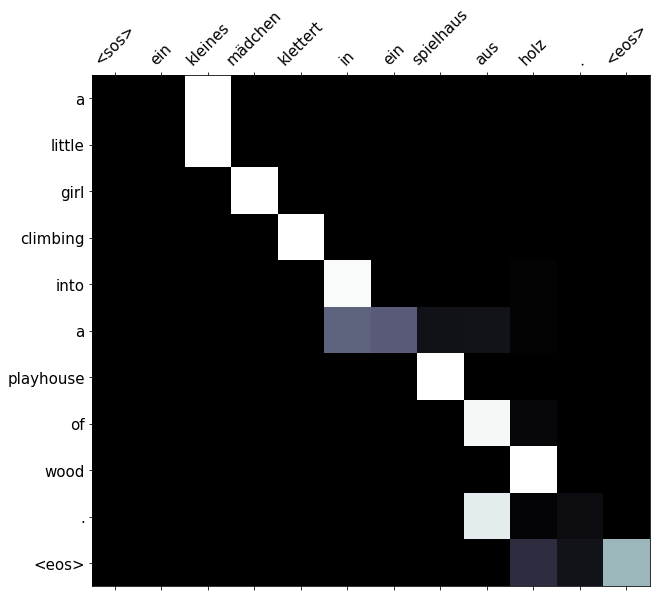

In [26]:
display_attention(src, translation, attention)

Let's see how well it translates an example that is not in the training set.

src = ['ein', 'junge', 'mit', 'kopfhörern', 'sitzt', 'auf', 'den', 'schultern', 'einer', 'frau', '.']
trg = ['a', 'boy', 'wearing', 'headphones', 'sits', 'on', 'a', 'woman', "'s", 'shoulders', '.']
predicted trg = ['a', 'boy', 'in', 'headphones', 'sits', 'on', 'the', 'shoulders', 'of', 'a', 'woman', '.', '<eos>']


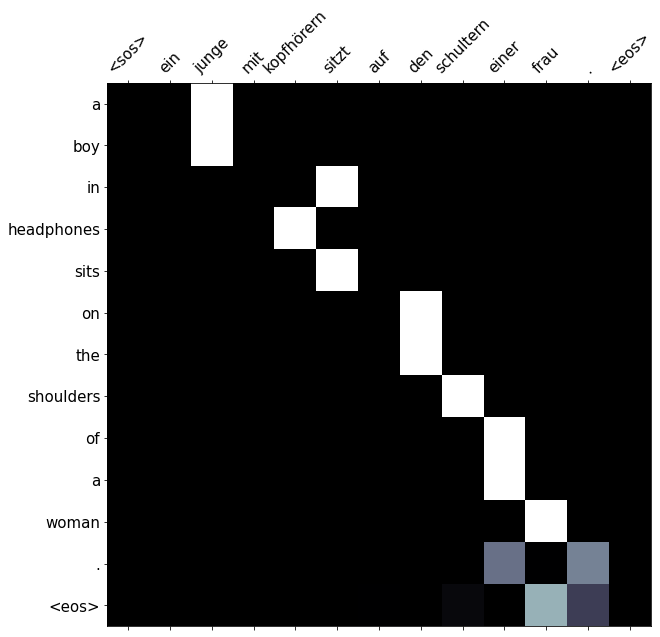

In [27]:
example_idx = 2
src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']
print(f'src = {src}')
print(f'trg = {trg}')
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(f'predicted trg = {translation}')
display_attention(src, translation, attention)

src = ['ein', 'kleines', 'kind', 'steht', 'allein', 'auf', 'einem', 'zerklüfteten', 'felsen', '.']
trg = ['a', 'young', 'child', 'is', 'standing', 'alone', 'on', 'some', 'jagged', 'rocks', '.']
predicted trg = ['a', 'young', 'child', 'stands', 'alone', 'on', 'a', 'rock', 'rock', '.', '<eos>']


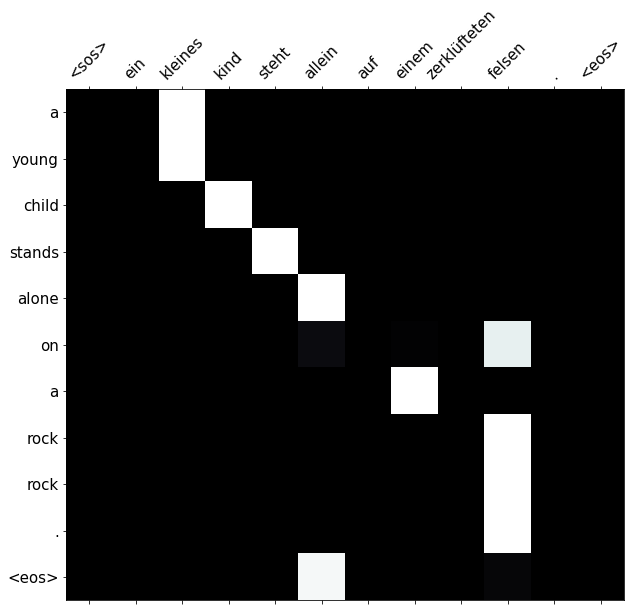

In [28]:
example_idx = 10
src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']
print(f'src = {src}')
print(f'trg = {trg}')
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(f'predicted trg = {translation}')
display_attention(src, translation, attention)

src = ['drei', 'mädchen', ',', 'von', 'denen', 'eines', 'gerade', 'trinkt', ',', 'stehen', 'in', 'einer', 'belebten', 'straße', 'und', 'schneiden', 'grimassen', '.']
trg = ['three', 'girls', 'make', 'faces', 'as', 'one', 'takes', 'a', 'drink', 'while', 'they', 'stand', 'in', 'a', 'busy', 'street', '.']
predicted trg = ['three', 'girls', 'drinking', 'in', 'a', 'crowded', 'street', ',', 'are', 'standing', 'in', 'a', 'crowded', 'street', 'and', 'cutting', 'faces', '.', '<eos>']


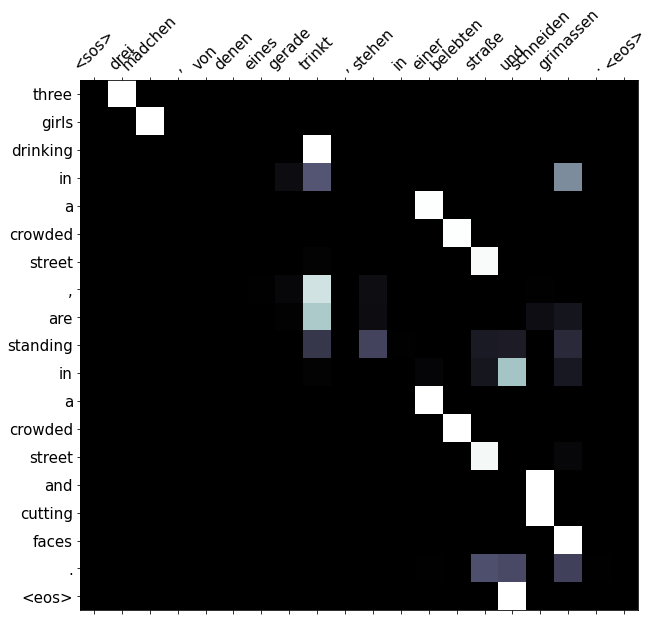

In [29]:
example_idx = 19
src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']
print(f'src = {src}')
print(f'trg = {trg}')
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(f'predicted trg = {translation}')
display_attention(src, translation, attention)

### BLEU


In [30]:
from torchtext.data.metrics import bleu_score
def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [31]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 32.51



We've now covered the first of our non-RNN using models! Next up is the Transformer model which doesn't even use convolutional layers - only linear layers and a lot of attention mechanisms.

### Credits

* [bentrevett](https://github.com/bentrevett/pytorch-seq2seq/blob/master/5%20-%20Convolutional%20Sequence%20to%20Sequence%20Learning.ipynb)